# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)
7. [Evaluate](#evaluate)
7. [Metrics](#metrics)
8. [Plots](#plots)

<a name=imports></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

In [108]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


***
<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [2]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2020-01-30          0.0
1  2020-01-31          0.0
2  2020-02-01          0.0
3  2020-02-02          0.0
4  2020-02-03          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vacc:
          Date  Total_Doses
0  2020-04-12          0.0
1  2020-04-13          0.0
2  2020-04-14          0.0
3  2020-

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [3]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          0.0
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          0.0
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0


#### Univariate 

In [4]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [5]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
          Date  Confirmed  Total_Doses
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
5  2020-02-04        0.0          0.0
USA:
          Date  Confirmed  Total_Doses
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0
5  2020-04-17    32175.0          0.0


### Normalize
Perform a Z-score normalization.

In [6]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
    Confirmed  Total_Doses
1  -0.662416    -0.627946
2  -0.662416    -0.627946
3  -0.662403    -0.627946
4  -0.662403    -0.627946
5  -0.662416    -0.627946 

USA Cases multivariate:
    Confirmed  Total_Doses
1  -0.596456    -0.932844
2  -0.584433    -0.932844
3  -0.562508    -0.932844
4  -0.546491    -0.932844
5  -0.538637    -0.932844 



### Create Splits
Break the dataset into train and test. The current split is 80:20.

In [7]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.2)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.2)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
564  -0.332037
565  -0.200599
566  -0.184543
567  -0.182312
568  -0.210064

[568 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
507   0.882933
508   0.655423
509   1.161010
510  -0.188293
511  -0.412010

[511 rows x 1 columns] 

India:
      Confirmed  Total_Doses
1    -0.662416    -0.627946
2    -0.662416    -0.627946
3    -0.662403    -0.627946
4    -0.662403    -0.627946
5    -0.662416    -0.627946
..         ...          ...
564  -0.332037     0.649820
565  -0.200599     0.663746
566  -0.184543     0.676817
567  -0.182312     0.687132
568  -0.210064     0.702473

[568 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
1    -0.596456    -0.932844
2    -0.584433    -0.932844
3    -0.562508    -0.932844
4    -0.546491    -0.932844
5    -0.538637    -0.932844
..         ...          ...
50

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [8]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [9]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(568, 1) (143, 1)
(568, 2) (143, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [10]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [11]:
timesteps = 14

In [12]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)

In [13]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (554, 14, 1) (554, 1)
Multivariate India shape: (554, 14, 2) (554, 2)


The univariate array shape for the India dataset has 566 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 566 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

***
<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [14]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [15]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
______________________________

In [16]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
____________________________

***
<a name=train></a>
## Train 

In [17]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [18]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [19]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 2s 32ms/step - loss: 0.4136 - mae: 0.4136
Epoch 2/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1555 - mae: 0.1555
Epoch 3/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1486 - mae: 0.1486
Epoch 4/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1306 - mae: 0.1306
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1205 - mae: 0.1205
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0983 - mae: 0.0983
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0984 - mae: 0.0984
Epoch 8/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1043 - mae: 0.1043
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1048 - mae: 0.1048
Epoch 10/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0891 - mae: 0.0891
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 11ms/step - loss: 0.0519 - mae: 0.0519
Epoch 87/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0514 - mae: 0.0514
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0505 - mae: 0.0505
Epoch 89/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0547 - mae: 0.0547
Epoch 90/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0573 - mae: 0.0573
Epoch 91/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0519 - mae: 0.0519
Epoch 92/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0507 - mae: 0.0507
Epoch 93/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0501 - mae: 0.0501
Epoch 94/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0549 - mae: 0.0549
Epoch 95/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0542 - mae: 0.0542
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 13ms/step - loss: 0.0452 - mae: 0.0452
Epoch 171/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0433 - mae: 0.0433
Epoch 172/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0436 - mae: 0.0436
Epoch 173/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0454 - mae: 0.0454
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0429 - mae: 0.0429
Epoch 175/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0451 - mae: 0.0451
Epoch 176/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.0430
Epoch 177/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0464 - mae: 0.0464
Epoch 178/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0464 - mae: 0.0464
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0462 - mae: 0.0462
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 13ms/step - loss: 0.0361 - mae: 0.0361
Epoch 255/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0344 - mae: 0.0344
Epoch 256/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0348 - mae: 0.0348
Epoch 257/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0395 - mae: 0.0395
Epoch 258/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0360 - mae: 0.0360
Epoch 259/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0345 - mae: 0.0345
Epoch 260/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0364 - mae: 0.0364
Epoch 261/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0345 - mae: 0.0345
Epoch 262/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0371 - mae: 0.0371
Epoch 263/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0377 - mae: 0.0377
Epoch 264/300
18/18 [=======================

In [20]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 32ms/step - loss: 0.3975 - mae: 0.3975
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 0.2059 - mae: 0.2059
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1542 - mae: 0.1542
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1453 - mae: 0.1453
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1430 - mae: 0.1430
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1407 - mae: 0.1407
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1378 - mae: 0.1378
Epoch 8/300
16/16 [==============================] - 0s 14ms/step - loss: 0.1365 - mae: 0.1365
Epoch 9/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1328 - mae: 0.1328
Epoch 10/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1347 - mae: 0.1347
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 0.0773 - mae: 0.0773
Epoch 87/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0749 - mae: 0.0749
Epoch 88/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0748 - mae: 0.0748
Epoch 89/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0805 - mae: 0.0805
Epoch 90/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0761 - mae: 0.0761
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0763 - mae: 0.0763
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0748 - mae: 0.0748
Epoch 93/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0723 - mae: 0.0723
Epoch 94/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0707 - mae: 0.0707
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0693 - mae: 0.0693
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 12ms/step - loss: 0.0566 - mae: 0.0566
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0574 - mae: 0.0574
Epoch 172/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0531 - mae: 0.0531
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0534 - mae: 0.0534
Epoch 174/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0550 - mae: 0.0550
Epoch 175/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0547 - mae: 0.0547
Epoch 176/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0595 - mae: 0.0595
Epoch 177/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0549 - mae: 0.0549
Epoch 178/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0530 - mae: 0.0530
Epoch 179/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0560 - mae: 0.0560
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 13ms/step - loss: 0.0443 - mae: 0.0443
Epoch 255/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0454 - mae: 0.0454
Epoch 256/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0415 - mae: 0.0415
Epoch 257/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0420 - mae: 0.0420
Epoch 258/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0470 - mae: 0.0470
Epoch 259/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0472 - mae: 0.0472
Epoch 260/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0483 - mae: 0.0483
Epoch 261/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0453 - mae: 0.0453
Epoch 262/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0489 - mae: 0.0489
Epoch 263/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0475 - mae: 0.0475
Epoch 264/300
16/16 [=======================

In [21]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 1s 31ms/step - loss: 0.4409 - mae: 0.4409
Epoch 2/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1909 - mae: 0.1909
Epoch 3/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1018 - mae: 0.1018
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0823 - mae: 0.0823
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0692 - mae: 0.0692
Epoch 6/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0623 - mae: 0.0623
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0620 - mae: 0.0620
Epoch 8/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0534 - mae: 0.0534
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0490 - mae: 0.0490
Epoch 10/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0461 - mae: 0.0461
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 13ms/step - loss: 0.0319 - mae: 0.0319
Epoch 87/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0335 - mae: 0.0335
Epoch 88/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0329 - mae: 0.0329
Epoch 89/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0354 - mae: 0.0354
Epoch 90/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0355 - mae: 0.0355
Epoch 91/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0341 - mae: 0.0341
Epoch 92/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0347 - mae: 0.0347
Epoch 93/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0330 - mae: 0.0330
Epoch 94/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0325 - mae: 0.0325
Epoch 95/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0323 - mae: 0.0323
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 13ms/step - loss: 0.0268 - mae: 0.0268
Epoch 171/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0297 - mae: 0.0297
Epoch 172/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0271 - mae: 0.0271
Epoch 173/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0267 - mae: 0.0267
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0258 - mae: 0.0258
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0261 - mae: 0.0261
Epoch 176/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0258 - mae: 0.0258
Epoch 177/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0262 - mae: 0.0262
Epoch 178/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0256 - mae: 0.0256
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0266 - mae: 0.0266
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 12ms/step - loss: 0.0269 - mae: 0.0269
Epoch 255/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0239 - mae: 0.0239
Epoch 256/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0260 - mae: 0.0260
Epoch 257/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0270 - mae: 0.0270
Epoch 258/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0268 - mae: 0.0268
Epoch 259/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0257 - mae: 0.0257
Epoch 260/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0246 - mae: 0.0246
Epoch 261/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0248 - mae: 0.0248
Epoch 262/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0278 - mae: 0.0278
Epoch 263/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0279 - mae: 0.0279
Epoch 264/300
18/18 [=======================

In [22]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 32ms/step - loss: 0.5127 - mae: 0.5127
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 0.3030 - mae: 0.3030
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1607 - mae: 0.1607
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1042 - mae: 0.1042
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0952 - mae: 0.0952
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0881 - mae: 0.0881
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0824 - mae: 0.0824
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0754 - mae: 0.0754
Epoch 9/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0781 - mae: 0.0781
Epoch 10/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0793 - mae: 0.0793
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 0.0422 - mae: 0.0422
Epoch 87/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0494 - mae: 0.0494
Epoch 88/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0478 - mae: 0.0478
Epoch 89/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0501 - mae: 0.0501
Epoch 90/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0515 - mae: 0.0515
Epoch 91/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0459 - mae: 0.0459
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0503 - mae: 0.0503
Epoch 93/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0457 - mae: 0.0457
Epoch 94/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0418 - mae: 0.0418
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0408 - mae: 0.0408
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 12ms/step - loss: 0.0354 - mae: 0.0354
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0359 - mae: 0.0359
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0362 - mae: 0.0362
Epoch 173/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0347 - mae: 0.0347
Epoch 174/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0368 - mae: 0.0368
Epoch 175/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0343 - mae: 0.0343
Epoch 176/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0348 - mae: 0.0348
Epoch 177/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0355 - mae: 0.0355
Epoch 178/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0389 - mae: 0.0389
Epoch 179/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0366 - mae: 0.0366
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 13ms/step - loss: 0.0302 - mae: 0.0302
Epoch 255/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0320 - mae: 0.0320
Epoch 256/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0296 - mae: 0.0296
Epoch 257/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0321 - mae: 0.0321
Epoch 258/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0317
Epoch 259/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0318 - mae: 0.0318
Epoch 260/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0311 - mae: 0.0311
Epoch 261/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0310 - mae: 0.0310
Epoch 262/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0336 - mae: 0.0336
Epoch 263/300
16/16 [==============================] - 0s 11ms/step - loss: 0.0312 - mae: 0.0312
Epoch 264/300
16/16 [=======================

***
<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [23]:
import evaluate

#### Long-Term 

In [24]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [25]:
# Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [26]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

Epoch 1/10
18/18 [==============================] - 1s 30ms/step - loss: 0.0308 - mae: 0.0308
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0362 - mae: 0.0362
Epoch 3/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0396 - mae: 0.0396
Epoch 4/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0359 - mae: 0.0359
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0346 - mae: 0.0346
Epoch 6/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0330 - mae: 0.0330
Epoch 7/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0317
Epoch 8/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0305 - mae: 0.0305
Epoch 9/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0311 - mae: 0.0311
Epoch 10/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0340 - mae: 0.0340
Epoch 1/10
18/18 [==============================] - 0s 28ms

21/21 [==============================] - 0s 13ms/step - loss: 0.0305 - mae: 0.0305
Epoch 9/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0308 - mae: 0.0308
Epoch 10/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0284 - mae: 0.0284
Epoch 1/10
22/22 [==============================] - 1s 26ms/step - loss: 0.0302 - mae: 0.0302
Epoch 2/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0293 - mae: 0.0293
Epoch 3/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0300 - mae: 0.0300
Epoch 4/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0271 - mae: 0.0271
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0291 - mae: 0.0291
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0295 - mae: 0.0295
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0302 - mae: 0.0302
Epoch 8/10
22/22 [==============================] - 0s 13ms/step - los

19/19 [==============================] - 0s 13ms/step - loss: 0.0625 - mae: 0.0625
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0596 - mae: 0.0596
Epoch 7/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0579 - mae: 0.0579
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0588 - mae: 0.0588
Epoch 9/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0543 - mae: 0.0543
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0556 - mae: 0.0556
Epoch 1/10
19/19 [==============================] - 0s 26ms/step - loss: 0.0599 - mae: 0.0599
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0603 - mae: 0.0603
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0586 - mae: 0.0586
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0589 - mae: 0.0589
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - los

In [27]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

Epoch 1/10
18/18 [==============================] - 0s 27ms/step - loss: 0.0249 - mae: 0.0249
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0231 - mae: 0.0231
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0238 - mae: 0.0238
Epoch 4/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0237 - mae: 0.0237
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0251 - mae: 0.0251
Epoch 6/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0236 - mae: 0.0236
Epoch 7/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0239 - mae: 0.0239
Epoch 8/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0248 - mae: 0.0248
Epoch 9/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0252 - mae: 0.0252
Epoch 10/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0270 - mae: 0.0270
Epoch 1/10
18/18 [==============================] - 0s 28ms

21/21 [==============================] - 0s 13ms/step - loss: 0.0238 - mae: 0.0238
Epoch 9/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0236 - mae: 0.0236
Epoch 10/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0229 - mae: 0.0229
Epoch 1/10
22/22 [==============================] - 1s 26ms/step - loss: 0.0235 - mae: 0.0235
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0254 - mae: 0.0254
Epoch 3/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0242 - mae: 0.0242
Epoch 4/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0245 - mae: 0.0245
Epoch 5/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0229 - mae: 0.0229
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0229 - mae: 0.0229
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0233 - mae: 0.0233
Epoch 8/10
22/22 [==============================] - 0s 13ms/step - los

19/19 [==============================] - 0s 13ms/step - loss: 0.0435 - mae: 0.0435
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0459 - mae: 0.0459
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0461 - mae: 0.0461
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0419 - mae: 0.0419
Epoch 9/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0431 - mae: 0.0431
Epoch 10/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0416 - mae: 0.0416
Epoch 1/10
19/19 [==============================] - 0s 27ms/step - loss: 0.0449 - mae: 0.0449
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0435 - mae: 0.0435
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0427 - mae: 0.0427
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0430 - mae: 0.0430
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - los

In [28]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-0.19233012  0.7117151  -0.19865063  0.723203   -0.20609736  0.73321956
 -0.20870498  0.74087006 -0.20924285  0.7538692  -0.20988905  0.7699225
 -0.21312949  0.78508997 -0.21719936  0.8028075  -0.21991244  0.818253
 -0.22359425  0.83285177 -0.23004496  0.8419919  -0.23311028  0.85829896
 -0.2375567   0.8781963  -0.24640465  0.8978622  -0.12005055  0.9541247
 -0.12088588  0.9730227  -0.12379658  0.98853695 -0.12923086  0.99977195
 -0.12921742  1.018804   -0.12865952  1.0420882  -0.13271597  1.0610926
 -0.13598731  1.0810528  -0.1410161   1.1003407  -0.14711168  1.1211872
 -0.15102157  1.137308   -0.15384355  1.1555772  -0.15526566  1.1765184
 -0.15574321  1.1996346  -0.25853622  1.1732923  -0.26583207  1.1951109
 -0.27382922  1.2174859  -0.2814635   1.2344588  -0.287503    1.2537395
 -0.29328477  1.2769595  -0.29937518  1.2977184  -0.3077054   1.3183082
 -0.3155613   1.3360099  -0.32484233  1.3515023  -0.33693147  1.3644228
 -0.34613657  1.3800223  -0.35133636  1.398848   -0.35617027  

In [29]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(286,) (256,) (286, 2) (256, 2)


***
<a name=evaluate></a>
## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [126]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_np_long_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_long_denorm = np.round(yhat_uni_india_denorm)

In [137]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_np_long_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_long_denorm = np.round(yhat_uni_usa_denorm)

##### Multivariate

In [128]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[0::2][timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [129]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[0::2][timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

In [73]:
yhat_multi_india_long[0]

array([-0.25613042,  0.70980816])

##### Univariate 

In [74]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()

# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

ValueError: zero-dimensional arrays cannot be concatenated

In [75]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()

# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

ValueError: zero-dimensional arrays cannot be concatenated

##### Multivariate

In [130]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_short_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_short_denorm = np.round(yhat_multi_india_denorm)[0::2]

In [131]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_short_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_short_denorm = np.round(yhat_multi_usa_denorm)[0::2]

***
<a name=metrics></a>
## Get Metrics 
Return format: (mape, mae, rmse)

#### Long-Term

In [132]:
# Check to ensure data matches
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

##### Univariate

In [133]:
# Univariate Long-Term India
uni_india_eval_long = evaluate.evaluate(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm)
uni_india_eval_long.insert(0,'Univariate Long-Term India')
uni_india_eval_long

['Univariate Long-Term India', 80356589568.0, 19722.60546875, 36031.145]

In [138]:
# Univariate Long-Term USA
uni_usa_eval_long = evaluate.evaluate(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm)
uni_usa_eval_long.insert(0,'Univariate Long-Term USA')
uni_usa_eval_long

['Univariate Long-Term USA', 154.78094482421875, 153208.09375, 236029.14]

##### Multivariate

In [139]:
# Multivariate Long-Term India
multi_india_eval_long = evaluate.evaluate(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm)
multi_india_eval_long.insert(0,'Multivariate Long-Term India')
multi_india_eval_long

['Multivariate Long-Term India', 9441860608.0, 17228.333984375, 34075.75]

In [140]:
# Multivariate Long-Term USA
multi_usa_eval_long = evaluate.evaluate(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm)
multi_usa_eval_long.insert(0,'Multivariate Long-Term USA')
multi_usa_eval_long

['Multivariate Long-Term USA', 143.02410888671875, 144586.28125, 224566.44]

#### Short-Term Rolling Forecast

##### Univariate 

In [141]:
# Univariate Short-Term India
uni_india_eval_short = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_eval_short.insert(0,'Univariate Short-Term India')
uni_india_eval_short

['Univariate Short-Term India', 104825176064.0, 3904.650390625, 8231.256]

In [142]:
# Univariate Short-Term USA
uni_usa_eval_short = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_eval_short.insert(0,'Univariate Short-Term USA')
uni_usa_eval_short

['Univariate Short-Term USA', 36.79194259643555, 64817.75, 132251.67]

##### Multivariate

In [143]:
# Multivariate Short-Term India
multi_india_eval_short = evaluate.evaluate(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm)
multi_india_eval_short.insert(0,'Multivariate Short-Term India')
multi_india_eval_short

['Multivariate Short-Term India', 26251750000.0, 11358.469, 27704.258]

In [144]:
# Multivariate Short-Term USA
multi_usa_eval_short = evaluate.evaluate(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm)
multi_usa_eval_short.insert(0,'Multivariate Short-Term USA')
multi_usa_eval_short

['Multivariate Short-Term USA', 56.125156, 73786.38, 122041.84]

### Visualize performance
TODO: Still need to add multivariate metrics

In [165]:
d = [uni_india_eval_long,uni_usa_eval_long,uni_india_eval_short,uni_usa_eval_short,multi_india_eval_long,
    multi_usa_eval_long,multi_india_eval_short,multi_usa_eval_short]
metrics_table = pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])
metrics_table

,Models,MAPE,MAE,RMSE
0,Univariate Long-Term India,8.035659e+10,19722.605469,36031.144531
1,Univariate Long-Term USA,1.547809e+02,153208.093750,236029.140625
2,Univariate Short-Term India,1.048252e+11,3904.650391,8231.255859
3,Univariate Short-Term USA,3.679194e+01,64817.750000,132251.671875
4,Multivariate Long-Term India,9.441861e+09,17228.333984,34075.750000
5,Multivariate Long-Term USA,1.430241e+02,144586.281250,224566.437500
6,Multivariate Short-Term India,2.625175e+10,11358.468750,27704.257812
7,Multivariate Short-Term USA,5.612516e+01,73786.382812,122041.843750


***
<a name=plots></a>
## Plots
March 1st - 

In [147]:
%tensorboard --logdir logdir

Reusing TensorBoard on port 6006 (pid 12827), started 0:18:31 ago. (Use '!kill 12827' to kill it.)

#### Long-Term Rolling forecasts

##### Univariate

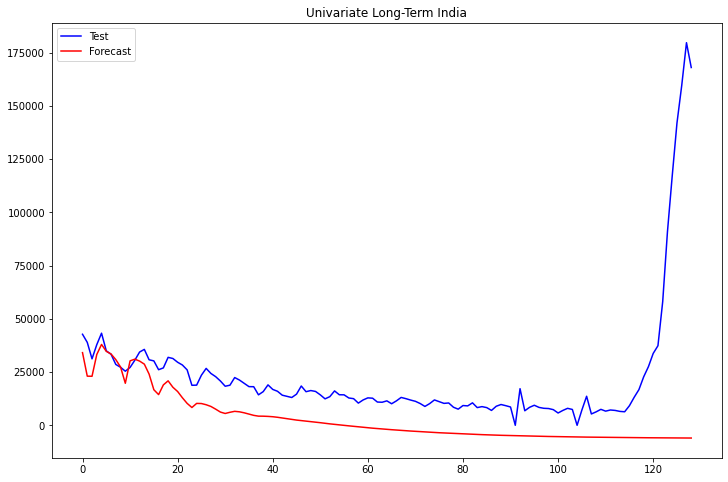

In [148]:
evaluate.plot_fore_test(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm, 'Univariate Long-Term India')

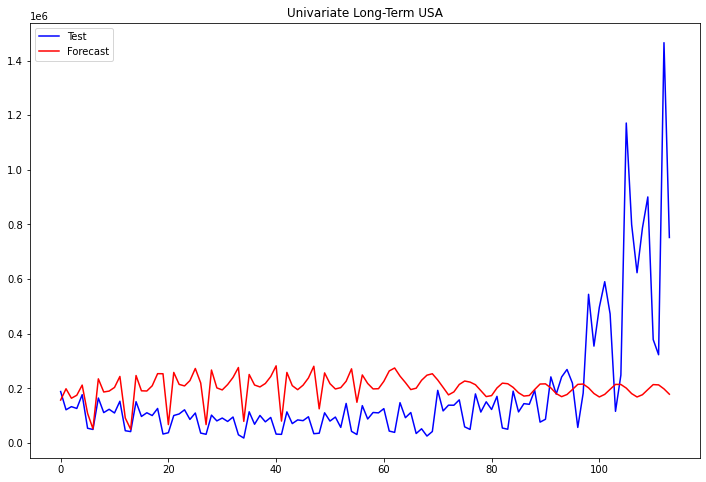

In [149]:
evaluate.plot_fore_test(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm, 'Univariate Long-Term USA')

##### Multivariate

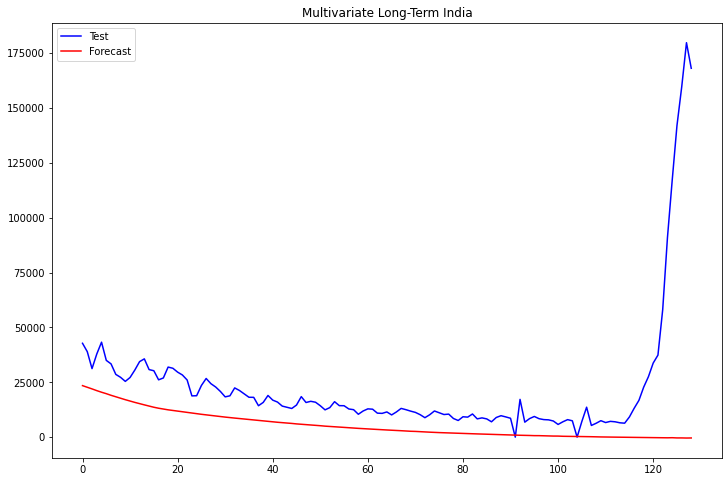

In [150]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm, "Multivariate Long-Term India")

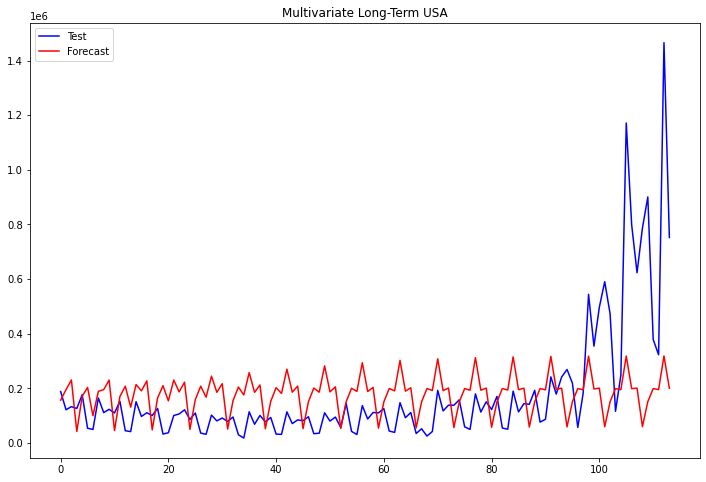

In [151]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm, "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

##### Univariate

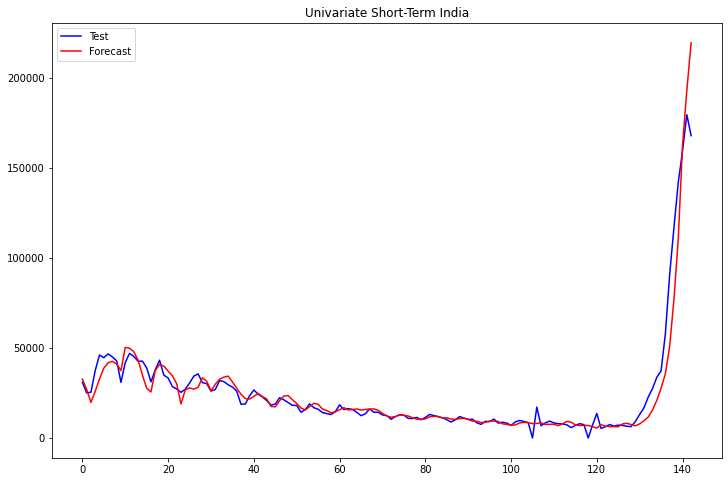

In [152]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

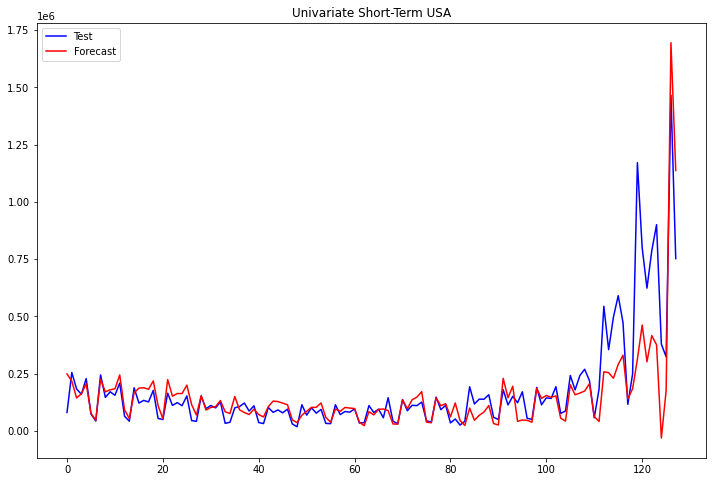

In [153]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

##### Multivariate

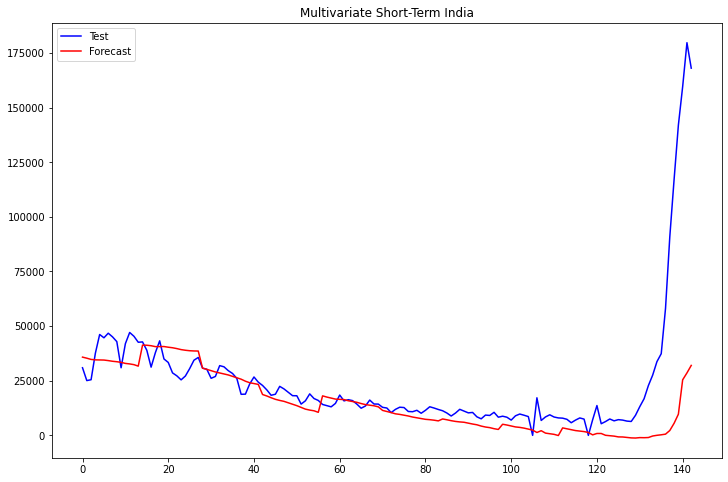

In [154]:
evaluate.plot_fore_test(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm, "Multivariate Short-Term India")

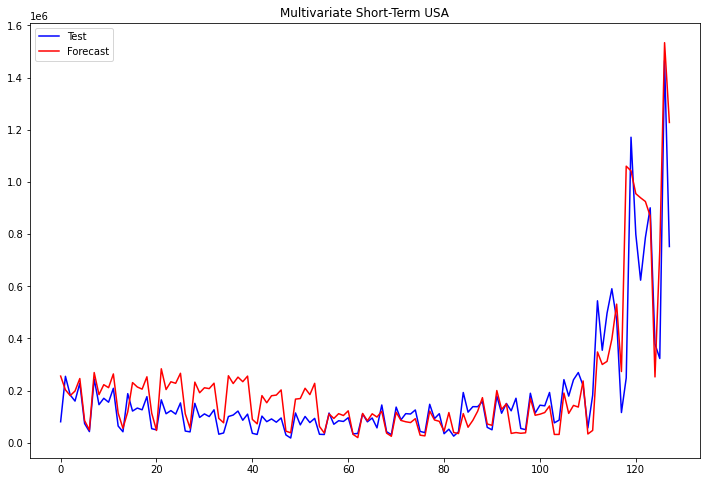

In [155]:
evaluate.plot_fore_test(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm, "Multivariate Short-Term USA")

***
## Save Results
Split = 80:20
India has 568 train, 143 test
Usa has 511 train, 143 test

Long-term predictions have 14 less days in test

In [160]:
dates = india_cases_df.values[1:,0]
dates_df = pd.to_datetime(dates)
dates_df[-129:]

DatetimeIndex(['2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07',
               '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11',
               '2021-09-12', '2021-09-13',
               ...
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10'],
              dtype='datetime64[ns]', length=129, freq=None)

In [164]:
y_india_uni_long_df = pd.DataFrame({'Date':dates[-129:], 'y_india_uni_long':india_uni_test_np_long_denorm})
y_india_uni_long_df

,Date,y_india_uni_long
0,2021-09-04,42766.0
1,2021-09-05,38948.0
2,2021-09-06,31222.0
3,2021-09-07,37875.0
4,2021-09-08,43263.0
...,...,...
124,2022-01-06,117100.0
125,2022-01-07,141986.0
126,2022-01-08,159632.0
127,2022-01-09,179723.0
